In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [73]:
train_data = pd.read_csv("./datasets/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [74]:
test_data = pd.read_csv("./datasets/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## EDA

In [75]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [76]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [77]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [78]:
def preprocess_data(df: pd.DataFrame):
    data = df.copy()

    def normalize_name(names):
        return " ".join([x.strip(",()[].\"'") for x in names.split(" ")])

    def ticket_number(ticket):
        return ticket.split(" ")[-1]

    def ticket_item(ticket):
        items = ticket.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])

    data["Name"] = data["Name"].apply(normalize_name)
    data["Ticket_number"] = data["Ticket"].apply(ticket_number)
    data["Ticket_item"] = data["Ticket"].apply(ticket_item)

    return data

In [79]:
preprocessed_train_data = preprocess_data(train_data)
preprocessed_test_data = preprocess_data(test_data)

In [174]:
train_df = preprocessed_train_data.copy()

In [175]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            714 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          204 non-null    object 
 11  Embarked       889 non-null    object 
 12  Ticket_number  891 non-null    object 
 13  Ticket_item    891 non-null    object 
dtypes: float64(2), int64(5), object(7)
memory usage: 97.6+ KB


In [176]:
categorical_features = ["Name", "Sex", "Embarked", "Ticket_number", "Ticket_item"]

In [177]:
median_age = train_df.groupby(by = ["Pclass", "Sex"], observed = True)["Age"].median().reset_index().rename(columns = { "Age": "Median_age" })
median_age

,Pclass,Sex,Median_age
0,1,female,35.0
1,1,male,40.0
2,2,female,28.0
3,2,male,30.0
4,3,female,21.5
5,3,male,25.0


In [178]:
df = pd.merge(train_df, median_age, on = ["Pclass", "Sex"], how = "left")

In [179]:
df["Age"] = df["Age"].fillna(df["Median_age"])
train_df = df.drop(columns = "Median_age")

In [180]:
train_df = train_df.drop(columns = ["PassengerId", "Ticket"])
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,0,3,Braund Mr Owen Harris,male,22.0,1,0,7.2500,NaN,S,21171,A/5
1,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,71.2833,C85,C,17599,PC
2,1,3,Heikkinen Miss Laina,female,26.0,0,0,7.9250,NaN,S,3101282,STON/O2.
3,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,53.1000,C123,S,113803,NONE
4,0,3,Allen Mr William Henry,male,35.0,0,0,8.0500,NaN,S,373450,NONE


In [181]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    int64  
 1   Pclass         891 non-null    int64  
 2   Name           891 non-null    object 
 3   Sex            891 non-null    object 
 4   Age            891 non-null    float64
 5   SibSp          891 non-null    int64  
 6   Parch          891 non-null    int64  
 7   Fare           891 non-null    float64
 8   Cabin          204 non-null    object 
 9   Embarked       889 non-null    object 
 10  Ticket_number  891 non-null    object 
 11  Ticket_item    891 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB


In [182]:
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])

In [ ]:
train_df = train_df.drop(columns = "Cabin")

In [186]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    int64  
 1   Pclass         891 non-null    int64  
 2   Name           891 non-null    object 
 3   Sex            891 non-null    object 
 4   Age            891 non-null    float64
 5   SibSp          891 non-null    int64  
 6   Parch          891 non-null    int64  
 7   Fare           891 non-null    float64
 8   Embarked       891 non-null    object 
 9   Ticket_number  891 non-null    object 
 10  Ticket_item    891 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [187]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

In [201]:
ord_encoder = OrdinalEncoder()
train_df["Pclass"] = pd.DataFrame(ord_encoder.fit_transform(train_df[["Pclass"]]))
train_df["Sex"] = train_df["Sex"].astype("category").cat.codes
train_df["Embarked"] = train_df["Embarked"].astype("category").cat.codes
train_df["Pclass"] = train_df["Pclass"].astype("int64")

In [212]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_number
0,0,2,108,1,22.0,1,0,7.2500,2,21171
1,1,0,190,0,38.0,1,0,71.2833,0,17599
2,1,2,353,0,26.0,0,0,7.9250,2,3101282
3,1,0,272,0,35.0,1,0,53.1000,2,113803
4,0,2,15,1,35.0,0,0,8.0500,2,373450


In [ ]:
label_encoder = LabelEncoder()
train_df["Name"] = label_encoder.fit_transform(train_df["Name"])

In [211]:
train_df = train_df.drop(columns = "Ticket_item")

In [225]:
train_df["Ticket_number"] = np.where(train_df["Ticket_number"] == "LINE", train_df["Ticket_number"].mode()[0], train_df["Ticket_number"])

In [227]:
train_df["Ticket_number"] = train_df["Ticket_number"].astype("int64")

In [228]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_number
0,0,2,108,1,22.0,1,0,7.2500,2,21171
1,1,0,190,0,38.0,1,0,71.2833,0,17599
2,1,2,353,0,26.0,0,0,7.9250,2,3101282
3,1,0,272,0,35.0,1,0,53.1000,2,113803
4,0,2,15,1,35.0,0,0,8.0500,2,373450


In [229]:
X = train_df.drop(columns = "Survived")
y = train_df["Survived"]

In [155]:
catboost_model = CatBoostClassifier(cat_features = categorical_features)
cross_val_score(catboost_model, X, y).mean()

Learning rate set to 0.008911
0:	learn: 0.6873952	total: 22.3ms	remaining: 22.3s
1:	learn: 0.6820574	total: 50ms	remaining: 25s
2:	learn: 0.6789308	total: 78.3ms	remaining: 26s
3:	learn: 0.6737777	total: 110ms	remaining: 27.3s
4:	learn: 0.6706654	total: 124ms	remaining: 24.6s
5:	learn: 0.6654319	total: 150ms	remaining: 24.8s
6:	learn: 0.6597917	total: 177ms	remaining: 25.1s
7:	learn: 0.6548161	total: 202ms	remaining: 25s
8:	learn: 0.6498781	total: 220ms	remaining: 24.2s
9:	learn: 0.6471963	total: 229ms	remaining: 22.7s
10:	learn: 0.6426575	total: 265ms	remaining: 23.8s
11:	learn: 0.6388634	total: 291ms	remaining: 24s
12:	learn: 0.6363048	total: 305ms	remaining: 23.2s
13:	learn: 0.6336814	total: 319ms	remaining: 22.4s
14:	learn: 0.6312618	total: 328ms	remaining: 21.5s
15:	learn: 0.6266401	total: 354ms	remaining: 21.8s
16:	learn: 0.6222798	total: 379ms	remaining: 21.9s
17:	learn: 0.6179600	total: 405ms	remaining: 22.1s
18:	learn: 0.6142904	total: 422ms	remaining: 21.8s
19:	learn: 0.61041

0.8327663046889711

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [267]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

In [268]:
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
maxabs_scaler = MaxAbsScaler()
robust_scaler = RobustScaler()

In [248]:
std_scaler.fit(X_train)

StandardScaler()

In [249]:
X_train_scaled = std_scaler.transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = std_scaler.feature_names_in_)
X_train_scaled_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_number
0,-1.498400,-1.581363,-1.393819,1.732419,1.373534,-0.483199,0.299998,0.593092,-0.438892
1,0.853965,-1.515323,-1.393819,-2.101661,1.373534,0.845101,-0.286074,-1.946557,-0.452972
2,0.853965,1.336045,-1.393819,-0.542346,-0.476306,-0.483199,-0.457430,0.593092,-0.445413
3,0.853965,1.499203,-1.393819,-1.422901,-0.476306,2.173400,-0.197098,0.593092,0.077707
4,0.853965,1.200081,0.717453,-0.615726,-0.476306,-0.483199,-0.492217,0.593092,4.339610


In [250]:
X_test_scaled_df = pd.DataFrame(std_scaler.transform(X_test), columns = std_scaler.feature_names_in_)
X_test_scaled_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_number
0,0.853965,-1.072467,0.717453,0.484967,-0.476306,-0.483199,-0.500024,0.593092,0.083023
1,-0.322218,0.858227,-1.393819,0.191449,-0.476306,-0.483199,-0.399907,0.593092,-0.094237
2,0.853965,-0.043022,-1.393819,-0.579036,-0.476306,-0.483199,-0.495400,-0.676733,-0.434959
3,0.853965,-0.823847,0.717453,-0.835864,-0.476306,-0.483199,-0.494946,0.593092,0.084108
4,-1.498400,-0.676228,0.717453,0.778485,-0.476306,-0.483199,-0.636367,0.593092,-0.283777


In [251]:
model = MLPClassifier(max_iter = 9999)
model.fit(X_train_scaled_df, y_train)

MLPClassifier(max_iter=9999)

In [252]:
y_pred = model.predict(X_test_scaled_df)

In [253]:
y_pred

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0], dtype=int64)

In [254]:
accuracy_score(y_test, y_pred)

0.8295964125560538

In [262]:
model = MLPClassifier()

param_grid = {
    'hidden_layer_sizes': [(50, 50), (50, 100), (100, 50), (100, 100), (200, 200)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [500, 1000, 2000],
    'batch_size': [32, 64, 128]
}

searcher = RandomizedSearchCV(
    estimator = model, 
    param_distributions = param_grid,
    cv = 5,
    n_iter = 10,
    n_jobs = -1
)

searcher.fit(X_train_scaled_df, y_train)

RandomizedSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic'],
                                        'alpha': [0.0001, 0.001, 0.01, 0.1],
                                        'batch_size': [32, 64, 128],
                                        'hidden_layer_sizes': [(50, 50),
                                                               (50, 100),
                                                               (100, 50),
                                                               (100, 100),
                                                               (200, 200)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [500, 1000, 2000],
                                        'solver': ['sgd', 'adam']})

In [263]:
searcher.best_estimator_

MLPClassifier(activation='tanh', batch_size=32, hidden_layer_sizes=(200, 200),
              learning_rate='adaptive', max_iter=2000, solver='sgd')

In [264]:
searcher.best_score_

0.7919088766692852

In [265]:
model = RandomForestClassifier()
model.fit(X_train_scaled_df, y_train)

RandomForestClassifier()

In [266]:
y_pred = model.predict(X_test_scaled_df)
accuracy_score(y_test, y_pred)

0.852017937219731

In [270]:
robust_scaler.fit(X_train)
X_train_scaled_df = pd.DataFrame(robust_scaler.transform(X_train), columns = robust_scaler.feature_names_in_)
X_test_scaled_df = pd.DataFrame(robust_scaler.transform(X_test), columns = robust_scaler.feature_names_in_)

In [296]:
rf_model = RandomForestClassifier(max_depth = 10)
rf_model.fit(X_train_scaled_df, y_train)

RandomForestClassifier(max_depth=10)

In [297]:
y_pred = rf_model.predict(X_test_scaled_df)
accuracy_score(y_test, y_pred)

0.852017937219731

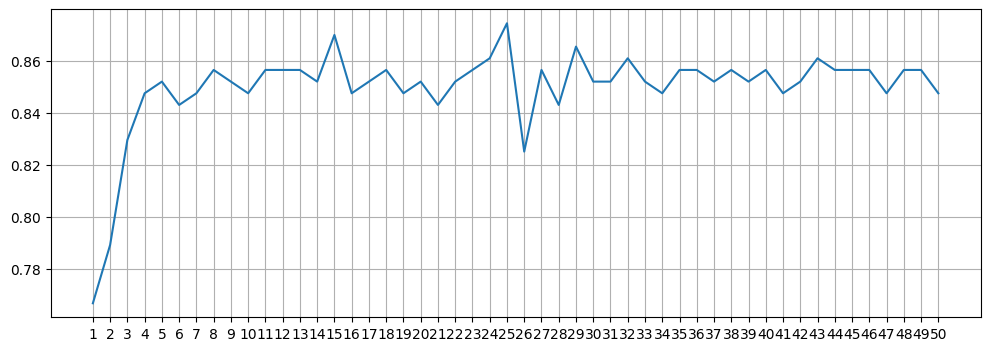

In [299]:
scores = []
for depth in range(1, 51):
    rf_model = RandomForestClassifier(max_depth = depth)
    rf_model.fit(X_train_scaled_df, y_train)
    y_pred = rf_model.predict(X_test_scaled_df)
    scores.append(accuracy_score(y_test, y_pred))

plt.figure(figsize = (12, 4))
plt.plot(scores)
plt.grid()
plt.xticks(range(50), labels = range(1, 51))
plt.show()

In [300]:
np.max(scores)

0.874439461883408

In [302]:
train_df.to_csv("./datasets/train_df.csv", sep = ",", index = False)